# Loader

Here we prepare a list containing all our slices from all the acquisitions in `spineGeneric_201904271322`

In [10]:
import nibabel as nib
import numpy as np
import json
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from skimage.transform import resize

with open('paths_small.json') as json_data:
    paths_centers = json.load(json_data,)

paths_centers = paths_centers['bids_path']
paths_subjects = []
paths_acq = []

#ds_raw will list all the pixel matrixes from the slices
ds_raw = []
#labels will list all the corresponding contrast labels
labels_sub = []
labels_sl = []

for center in paths_centers:
    
    sub_list = [sub for sub in os.listdir(center) if "sub" in sub]
    
    for subject in sub_list:
        path_subject = os.path.join(center, subject)        
        
        contrasts_lst = ["_T1w.nii.gz", "_T2w.nii.gz", "_T2star.nii.gz",
                        "_acq-T1w_MTS.nii.gz" , "_acq-MTon_MTS.nii.gz", 
                         "_acq-MToff_MTS.nii.gz"]

        for contrast in contrasts_lst:
            dest = subject + contrast
            path_acq = os.path.join(path_subject, "anat", dest)
            if os.path.exists(path_acq):
                paths_acq.append(path_acq)
                labels_sub.append(contrasts_lst.index(contrast))
                
                
for acq in tqdm_notebook(paths_acq, unit = "subject"):
    
    slices = nib.load(acq).get_data()
    if slices.size == 0:
        labels_sub.pop(paths_acq.index(acq))
        continue
    #we only take a couple of slices per acquisitions because
    #most are very similar and it would make way too much slices
    for i in range(np.shape(slices)[2]):
        ds_raw.append(slices[:,:,i])
        labels_sl.append(labels_sub[paths_acq.index(acq)])



#at this point ds contains the entire slices and labels_sl has the target label of each slice

# Preprocessing

Here we pre-process the data to ease the learning :
- center the images around the regions of interest
- normalize the intensity and brightness of the dataset 

In [12]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

#we crop the images
ds_cropped = []
for sl in ds_raw:
    if len(np.shape(sl)) >= 3 :
        sl = sl[:,:,0]
    h,l = np.shape(sl)[0], np.shape(sl)[1]
    ds_cropped.append(sl[h//3:2*h//3,l//3:2*l//3])
    
#for now we only add a normalization of each slice
ds = []
for sl in ds_cropped:
    ds.append(normalize(sl, norm = 'l2'))

And we add a visualization tool for qc

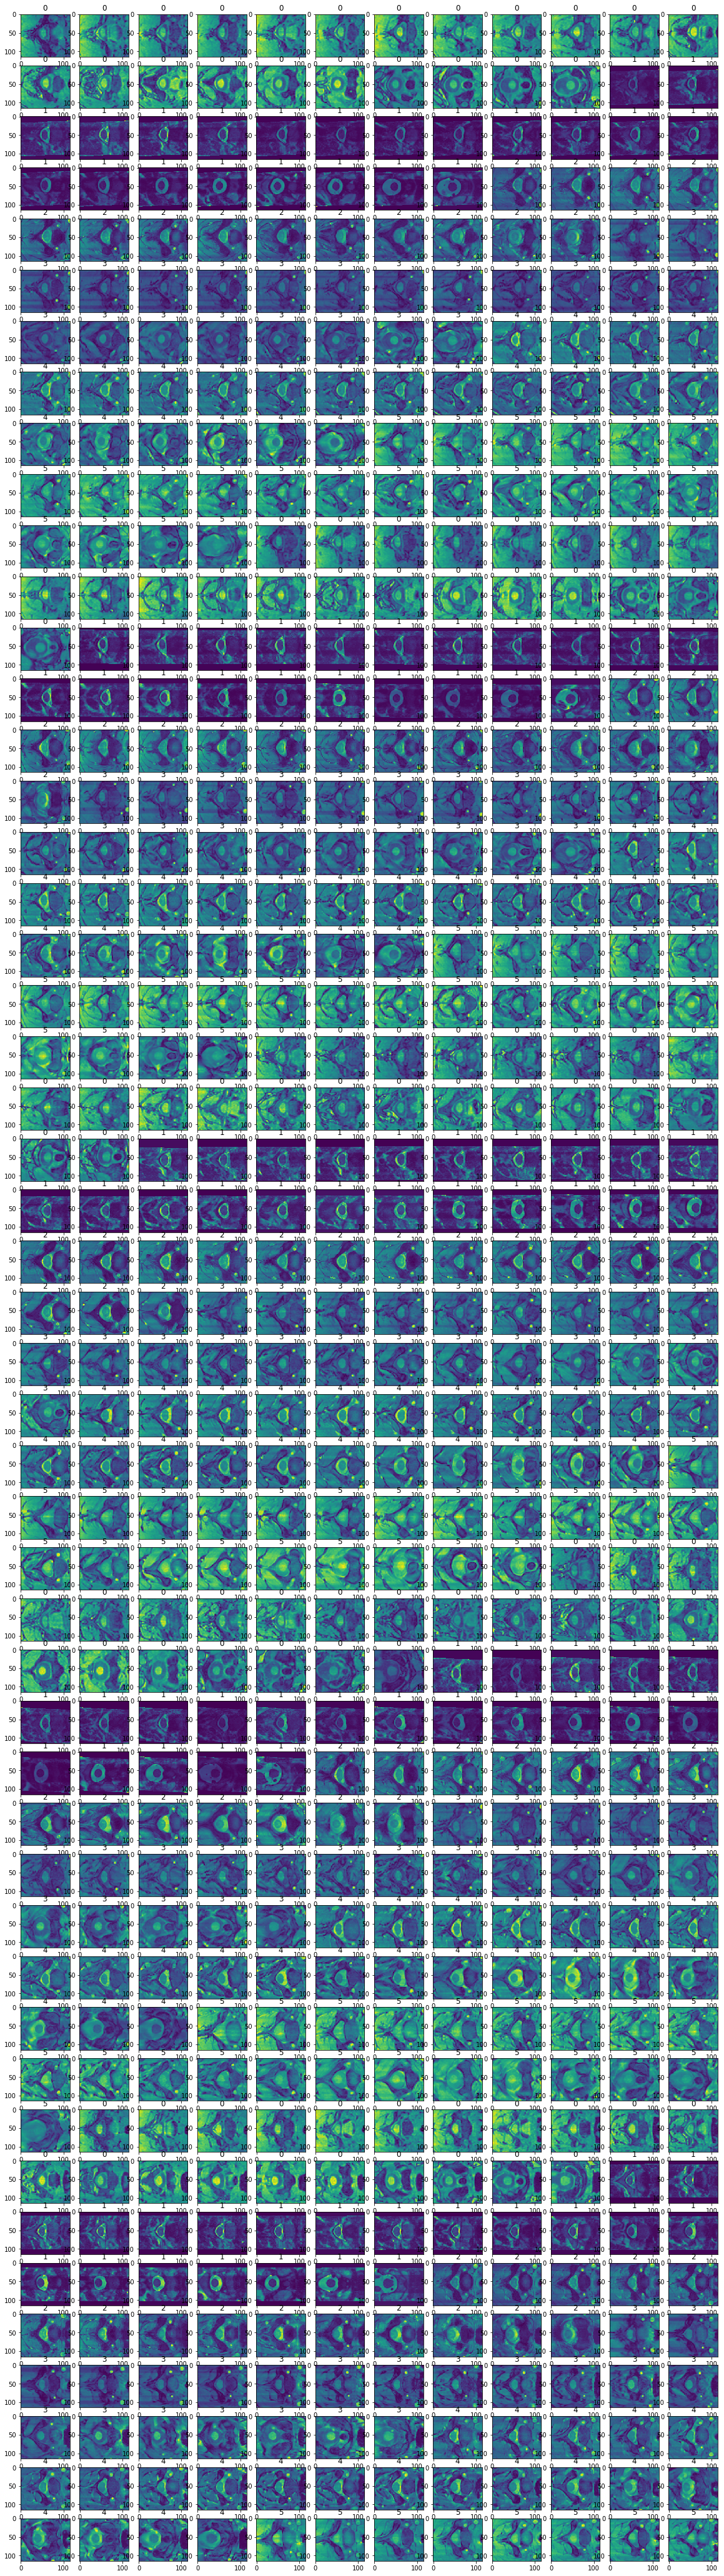

In [14]:
ncols = 12
nrows = 50
i,j = 0,0

fig, axes = plt.subplots(nrows, ncols, figsize = (20, (nrows * 3)//2))

for sl in tqdm_notebook(ds, unit = "slice"):
    axes[i,j].imshow(sl, aspect = 'auto')
    axes[i,j].set_title(labels_sl[i*ncols + j])
    j += 1
    if j >= ncols:
        j = 0
        i += 1
    #we have to stop here because figure size is limited
    if i == nrows:
        break

#this rendering step is a bit long
fig.show()

# Data-augmentation and conversion to tensors

In [47]:
from medicaltorch import datasets as mt_datasets
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import torchvision.utils as vutils
from torch import optim

from medicaltorch import transforms as mt_transforms
from medicaltorch import datasets as mt_datasets
from medicaltorch import losses as mt_losses
from medicaltorch import filters as mt_filters
from medicaltorch import metrics as mt_metrics

from copy import deepcopy

# Model

Here we define the architecture of the network in a PyTorch Module

In [44]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data.sampler import SubsetRandomSampler



class DownConv(nn.Module):
    def __init__(self, in_ch, out_ch, bn_momentum=0.1):
        super(DownConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, stride=1, padding=1)
        self.conv_bn = nn.BatchNorm2d(out_ch, momentum=bn_momentum)
    
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.conv_bn(x)
        return x

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Classifier(nn.Module):
    def __init__(self, drop_rate=0.4, bn_momentum=0.1):
        super(Classifier, self).__init__()
        self.conv1 = DownConv(1, 32, bn_momentum)
        self.mp1 = nn.MaxPool2d(2)
        
        self.conv2 = DownConv(32, 32, bn_momentum)
        self.mp2 = nn.MaxPool2d(2)
        
        self.conv3 = DownConv(32, 64, bn_momentum)
        self.mp3 = nn.MaxPool2d(2)       
        
        self.flat = Flatten()
        self.dense1 = nn.Linear(57600, 256)
        self.drop = nn.Dropout2d(drop_rate)
        self.dense2 = nn.Linear(256, 6)
        self.soft = nn.Softmax()

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.mp1(x1)
        
        x3 = self.conv2(x2)
        x4 = self.mp2(x3)
        
        x5 = self.conv3(x4)
        x6 = self.mp3(x5)
        
        x7 = self.flat(x6)
        x8 = self.dense1(x7)
        x9 = self.drop(x8)
        x10 = self.dense2(x9)
        x11 = self.soft(x10)
        
        return(x10)

#torch tensors are of the format (batch_size, n_channels, shape_of_image)
#a = torch.rand(100,1,244,244)
#print(Classifier().forward(a).shape)

torch.Size([100, 6])


/home/GRAMES.POLYMTL.CA/p112175/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Training the model